# Artigo 03: Reconhecer os Potenciais de Guerra(Bleach)


## Informações
* Autor: Thiago Cerqueira Borges
* Matrícula: 190117508
* GitHub: Thiago-Cerq

## Objetivo
> O objetivo deste artigo é treinar um modelo que distingue e categorize personagem do anime Bleach que são considerados potenciais de Guerra, personagem que são fortes o suficientes para impedir o plano do vilão Yhwach do arco Thousand-Year Blood War.

# Passo 01: Baixar imagens dos tipos de guerreiros.
> Intalar as depêndecias
> Importar as funçoes que serão ultilizadas no artigo.

In [1]:
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai
!pip install -Uqq fastbook

In [2]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=50): return L(ddg_images(term, max_results=max_images)).itemgot('image')
     

> O primeiro teste será feito baixando apenas uma imagem de um guerreiro de cada tipo :

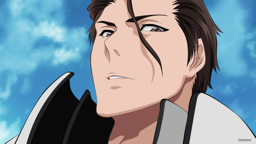

In [5]:
download_url(search_images('Aizen Sousuke', max_images=1)[0], 'Aizen.jpg', show_progress=True)
Image.open('Aizen.jpg').to_thumb(256,256)

Imagem 1:Aizen Sousuke. Fonte: Bleach.

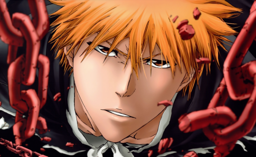

In [6]:
download_url(search_images('Kurosaki Ichigo', max_images=1)[0], 'Ichigo.jpg', show_progress=True)
Image.open('Ichigo.jpg').to_thumb(256,256)

Imagem 2: Kurosaki Ichigo. Fonte: Bleach.


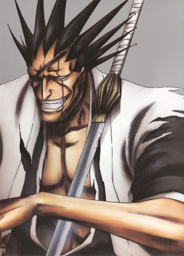

In [9]:
download_url(search_images('Zaraki', max_images=1)[0], 'Zaraki.jpg', show_progress=True)
Image.open('Zaraki.jpg').to_thumb(256,256)

Imagem 3: Zaraki Kenpachi. Fonte: Bleach.


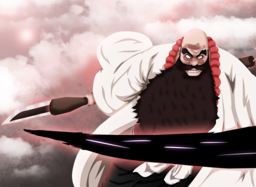

In [14]:
download_url(search_images('Ichibe', max_images=1)[0], 'Ichibe.jpg', show_progress=True)
Image.open('Ichibe.jpg').to_thumb(256,256)

Imagem 4:Ichibe Hyosube. Fonte: Bleach.


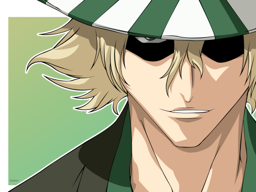

In [15]:
download_url(search_images('Urahara', max_images=1)[0], 'Urahara.jpg', show_progress=True)
Image.open('Urahara.jpg').to_thumb(256,256)

Imagem 5: Urahara Kisuke. Fonte: Bleach.

> Verificamos se as imagens baixadas estão corretas. Elas serão usadas como inferência.

> Então podemos baixar um grande volume delas.

In [16]:
searches = 'Aizen', 'Ichigo', 'Zaraki', 'Ichibe', 'Urahara'
path = Path('Pilares')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} face'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} manga image'))
    sleep(10)

    resize_images(path/o, max_size=400, dest= path/o)

/home/thiago/2023.2/AM/fastaiOnCampus/.venv/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/thiago/2023.2/AM/fastaiOnCampus/.venv/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Foi utilizado o sleep para que não haja problemas no tráfego de informações.

> Essas imagens serão salvas em uma pasta cujo caminho está definido no path (Pilares).

# Passo 2: Treinamento



Antes de iniciar o treinamento do modelo de fato é necessário garantir que não haja imagens com erro para evitar futuros problemas:

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

30

Para treinar um modelo, é necessário utilizar os DataLoaders, que são objetos que incluem um conjunto de treinamento (as imagens usadas para criar o modelo) e um conjunto de validação (as imagens usadas para verificar a precisão do modelo, mas que não são usadas durante o treinamento). No fastai, podemos criar esses DataLoaders de forma simples utilizando um DataBlock e também visualizar exemplos de imagens a partir deles.
lo.

In [18]:
Pilares = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

dls = Pilares.dataloaders(path)

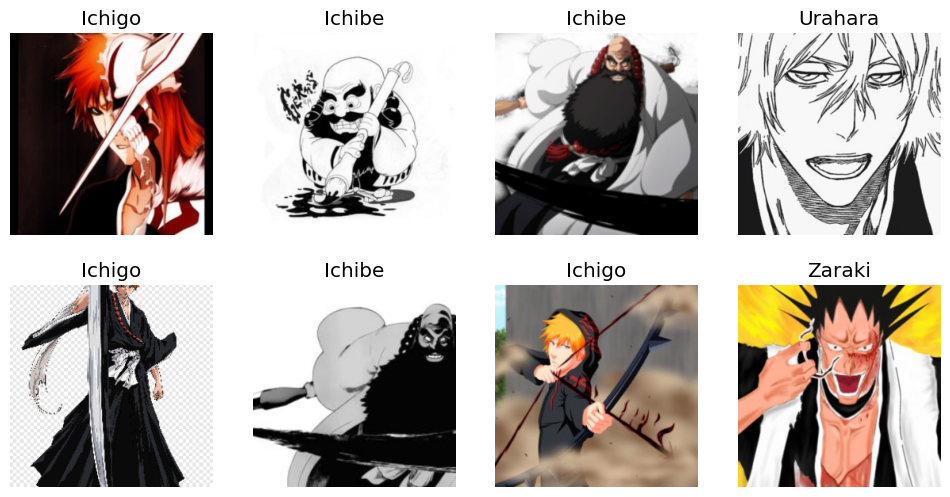

In [21]:
dls.valid.show_batch(max_n=8, nrows=2)

As duas células forçam a execução do garbage collector e do cache e tambem faz com que o output do resultado dos modelos treinados sejam exibidos corretamente. Basicamente limpando resultados de execuções antigas e lixo de memoria.

In [22]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

20336

In [23]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

# Passo 3: Treinando

Após criar o Datablock, o modelo é treinado com a ajuda do objeto "Learner". Ele é configurado com três argumentos: o primeiro é um DataLoader (dls) que contém o conjunto de dados de treinamento do modelo; o segundo é a arquitetura ResNet18 que será usada como base para o modelo; e o terceiro é a métrica usada para avaliar a performance do modelo, que neste caso é a taxa de erro.

Para realizar o ajuste fino do modelo, é utilizado o método "fine_tune()". Esse método realiza um treinamento adicional do modelo usando os pesos pré-treinados da ResNet18 como ponto de partida.

### ResNet-18

 ResNet-18 é uma das versões mais simples da arquitetura ResNet. Ele possui 18 camadas, incluindo 16 camadas de convolução e 2 camadas totalmente conectadas. É uma escolha popular para tarefas de classificação de imagens, especialmente quando os recursos computacionais são limitados.

In [24]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.724029,0.698260,0.225564,00:25
1,0.590872,0.495661,0.150376,00:23
2,0.443385,0.449033,0.127820,00:22
3,0.335366,0.487407,0.127820,00:21
4,0.265696,0.484336,0.135338,00:19
5,0.215197,0.479610,0.127820,00:19


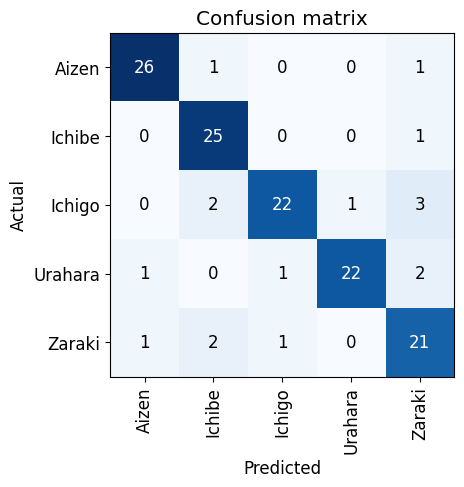

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### ResNet-34

ResNet-34 é uma versão um pouco mais profunda do que o ResNet-18, com 34 camadas no total. Ele mantém a mesma arquitetura básica, mas é mais profundo, o que pode ajudar a melhorar o desempenho em tarefas mais desafiadoras.

In [26]:
learn02 = vision_learner(dls, resnet34, metrics=error_rate)
learn02.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.877138,0.714417,0.225564,01:03
1,0.604115,0.445132,0.165414,01:03
2,0.414811,0.364148,0.127820,01:03
3,0.308973,0.364339,0.120301,01:03
4,0.240003,0.366404,0.120301,01:03
5,0.188657,0.365359,0.120301,01:03


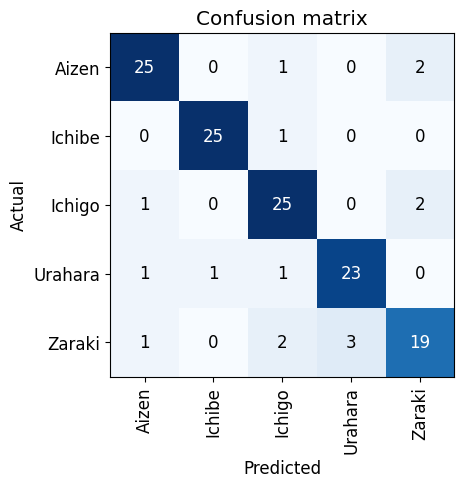

In [27]:
interp = ClassificationInterpretation.from_learner(learn02)
interp.plot_confusion_matrix()

### ResNet-50

ResNet-50, ResNet-101, ResNet-152: Essas são variantes mais profundas das ResNets, com 50, 101 e 152 camadas, respectivamente. Elas usam blocos residuais mais profundos e são mais poderosas em tarefas de visão computacional, como detecção de objetos e segmentação de imagens.

In [28]:
learn03 = vision_learner(dls, resnet50, metrics=error_rate)
learn03.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.402003,0.438400,0.127820,07:32
1,0.297590,0.413719,0.090226,07:28
2,0.220586,0.313052,0.105263,07:27
3,0.163748,0.311647,0.097744,07:32
4,0.125577,0.305127,0.105263,07:44
5,0.100009,0.304287,0.105263,07:46


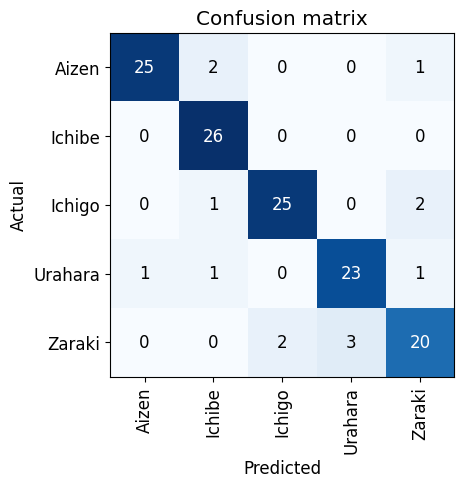

In [29]:
interp = ClassificationInterpretation.from_learner(learn03)
interp.plot_confusion_matrix()

# Testando o modelo

Com o modelo treinado, ao executar a última tela, receberá um prompt que informará o tipo de potencial presente na foto, a probabilidade de ser o tipo de potencial previsto e a imagem inserida.

É o Aizen.
Probabilidade de ser o Aizen: 99.83%


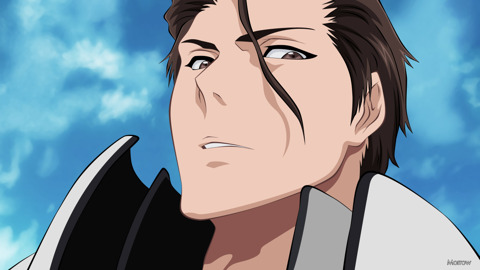

In [46]:
prediction_photo='Aizen.jpg'

W_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É o {W_type}.")
print(f"Probabilidade de ser o {W_type}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

É o Ichigo.
Probabilidade de ser o Ichigo: 99.97%


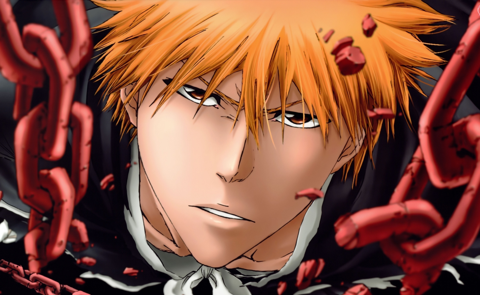

In [45]:
prediction_photo='Ichigo.jpg'

W_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É o {W_type}.")
print(f"Probabilidade de ser o {W_type}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

É o Zaraki.
Probabilidade de ser o Zaraki: 99.99%


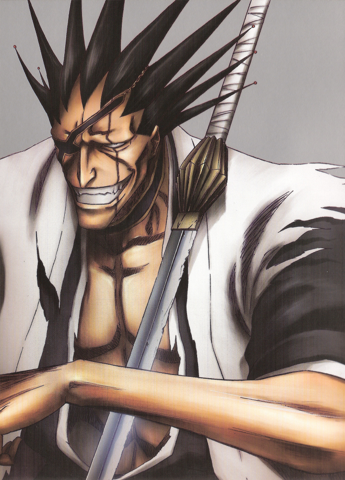

In [44]:
prediction_photo='Zaraki.jpg'

W_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É o {W_type}.")
print(f"Probabilidade de ser o {W_type}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

É o Ichibe.
Probabilidade de ser o Ichibe: 100.00%


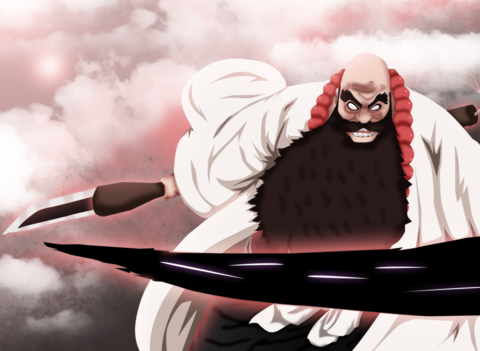

In [43]:
prediction_photo='Ichibe.jpg'

W_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É o {W_type}.")
print(f"Probabilidade de ser o {W_type}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

É o Urahara.
Probabilidade de ser o Urahara: 99.99%


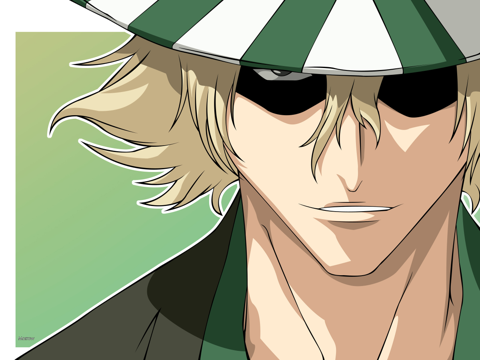

In [40]:
prediction_photo='Urahara.jpg'

W_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É o {W_type}.")
print(f"Probabilidade de ser o {W_type}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

A resnet50 teve o melhor desempenho em relaçaõ a precisaõ, porém é a rede que necessita de mais recursos e tempo, por isso é importante sempre ánalisar qual e testar qual rede melhor se encaixa a situação.

# Conclusão
A utilização do fastai simplifica significativamente o processo de treinamento de modelos para reconhecimento de imagens. Minha principal dificuldade pessoal estava relacionada à linguagem utilizada, uma vez que não possuía conhecimento prévio nessa área, porem com exercicio das atividades sinto mais confiante a desenvolver ultilizadno python. 

In [53]:
learn.export("model18.pkl")

In [54]:
learn02.export("model34.pkl")

In [55]:
learn03.export("model50.pkl")

## Link para acessar a aplicação no p Hugging Face 🤗
https://huggingface.co/spaces/fastaioncampus/Bleach

# Referências

> Jeremy Howard and Sylvain Gugge. FastBook. Disponível em https://github.com/fastai/fastbook.
Acessado e 10 de Setembro de 2023.023

> Repositorio da Disciplina Disponível em https://github.com/fabraz/fastaiOnCampus. Acessado em 10 de Setembro de 2023.